## Project Report - Pulse Rate Estimation

### Code Description
The PulseRate Algorithm is to analyze the PPG and 3-axis accelerometer signals and estimate pulse rate.    

The script contains two parts: data exploration and pulse rate estimates. In order to run the script, the following libraires need to installed:
- numpy
- scipy
- matplotlib
- glob

The Troika dataset is used for testing the algorithm, which can be downloaded from [here](https://github.com/udacity/nd320-c4-wearable-data-project-starter/tree/master/part_1/datasets) by running 
`git clone https://github.com/udacity/nd320-c4-wearable-data-project-starter/tree/master/part_1/datasets`.   

--------
### Overview
The main directory for input data is `./datasets/troika/training_data`, where you can find two types of `.mat` files. These files are from the Troika dataset, and more details can be found in the *Data Description* section. Files start with `DATA*`contain measured ECG, PPG, and accelerometer signal data, which were used for computing the estimates. Those start with `REF*`contain the pulse rates calculated from measured ECG data, which serve as the ground truth heart rates.     

1) To explore the dataset, you can run the `data_explore()`function, and two randomly picked samples with ECG, PPG (two channels), Accelerometer (three axis) signals plotted. You can modify the variable `plot_num`of the `data_explore`function to decide how many samples you would like to compare.     
2) To estimate the pulse rate, you simply need to run the `Evaluate()`, which will call the main function, `RunPulseRateAlgorithm()`, to analyze data and evaluate the estimates. Function `AggregateErrorMetric()`will compute the final output is the mean absolute error at 90% availability between the estimated frequency and the ground truth reference pulse rate. 

When run the script as its default setting, the algorithm's final output MAE is 14.05 BPM in training data and 4.5 BPM for test unit. Thus, it is recommended to run the script using default values. 

### Data Description
The data used to design and validate the algorithm is a subset from the **Troika**[1] dataset.    
The dataset consists of wearable signals recorded from 11 individuals between 18 to 25 years' old performing 12 sessions of tests, TYPE01 and TYPE02, with `subject 4` performed both types of experiments. The PPG and three-axis accelerometer signals were recorded from wrist, while the ECG data was obtained from wet ECG sensors. The sampling rate for all signals is 125 Hz.    
There are two types of data: TYPE01 and TYPE02, which were recorded when subjects were instructed to rest, job and run following two sets of speed profiles on a treadmill. Each session lasts for 5 min. The ground truth is the calculated heart rate from the simultaneously recorded ECG signal from TYPE01 dataset. The heart rate is computed for every 8 seconds with 6 seconds overlapping in between.    

We used one channel of PPG signals and three-axis accelerometer signals for training, and compared the estimated frequency with the reference ECG signals. 

There are several drawbacks of the Troika dataset. The most significant one is the small sample size that there were only 12 subjects available. Additionally, the demographic information of the subjects is not sufficient that we only know the age range but not the distribution nor any other demographic details. Finally, we don't know if there is any variation in the lab setup, where the subjects were measured. The variation of lab setup and measuring equipment may also limit the generability of the dataset.    

Therefore, to build a more complete dataset, we may involve more subjects with diversed demographic distribution. We can also compare recordings from different settings to include more scenarios. 

### Algorithm Description
ECG signals are the gold standard in estimating pulse rate, because the ECG sensors measure the electrical activations of the heart muscle contraction. PPG sensors also measure cardiac activities, but PPG employs the discoloration of the ventricle to measure the heart rate. The systolic peak, the largest amplitude of PPG signals, usally appear near the R peaks from the ECG signal. When the heart contracts, blood leaves the ventricles, which result in a stronger PPG signal. When the heart relaxes, the blood will fill the ventricle and leads to a weaker reading on PPG sensor. This physiological feature of PPG signals make it a great alternative and non-invasive option to measure heart rate than ECG sensors. However, the PPG signals is more vulnerable to noise when compared with ECG signals. Thus, it would be useful to combine the accelerometer signals when estimating pulse rate, as motion also affect blood circulation.     

Our PulseRate algorithm takes advantage of this feature of PPG signals. We applied a bandpass filter to restrict the signal between 40 BPM to 240 BPM. We identify the top 10 strongest PPG signals, and compared PPG signal with each axis of accelerometer signals to filter out the peak that may result from movement. Next, we calculated the mean absolute error between the estimated frequencies and the ground truth and selected the best estimate. The outputs of the algorithm consist of the following:
- Estimated frequency for hear beat. 
- Confidence value of the estimated frequncy as a ratio of the energy concentrated nearby to the full signal. 
- The mean absolute error between the estimated frequency and the ground truth. 

These outputs have met the requirement (train: 14.05BPM, test: 4.5 BPM). However, they may not be reliable, especially when the PPG and accelerometer signals are quite noisy.
As we can see from the data exploration, the accelerometer signals do not necessarily follow a periodic pattern but sometimes have big spikes due to non-periodic movement. This may result in inaccurate estimates. This can be improved by applying filters to reduce ppg signal noise. 

### Algorithm Performance

- The performance of the algorithm is measured by the MAE and confidence value. 
- The algorithm achieved 14.05 BPM MAE at 90% availability for trainig set, and has 4.5 BPM MAE for the unit test. 
- The algorithm doesn't take into account the distance between measured peaks from PPG data. When one peak is located, we can also use a distance window to restrict that any other peak discovered within certain time frame after the previous will be discarded because there has to be some refractory time between two consecutive peaks.    

-------
1. [Zhang, Zhilin, Zhouyue Pi, and Benyuan Liu. "TROIKA: A general framework for heart rate monitoring using wrist-type photoplethysmographic signals during intensive physical exercise." IEEE Transactions on biomedical engineering 62.2 (2014): 522-531.](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6905737&casa_token=HpayE91mAkQAAAAA:mmvreBfS5a4esravs1vX1QMN7f5PILYXFMwafGqLa-e9NWY2jbWZAXhhGhoOeuLdOa6J2LJXw2E&tag=1)

In [3]:
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal

import matplotlib.pyplot as plt

import glob


def resample(data, fs=125):
    """
    Resample ndarray data.

    Args:
        data (array_like): the data to be resampled.
        fs (float, optional): The sampling frequency.
            It is used to create the x-coordinates <ts> to
            evaluate the interpolated.
            Defaults to 125.

    Returns:
        data_interp (ndarray): the interpolated values with
        the same shape as <data>.
    """
    s = len(data)
    ts = np.arange(0, s / fs)
    data_interp = np.interp(ts, range(s), data)
    return data_interp


def data_explore(path="./datasets/troika/training_data", plot_num=2, save_fig=True):
    """
    Plot the resampled ecg, ppg, accelerometer signals to explore the features
     of the data.

    Args:
        path (str): the parent path to <data_fls> and <ref_fls> subdirectories.
        plot_num (int, optional): Value to return how many samples to explore.
            Defaults to 2.
        save_fig (bool, optional): Whether to save the data exploratory figures.
            Defaults to True.
    """
    data_fls = sorted(glob.glob(path + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(path + "/REF_*.mat"))
    print("Found {} data files and {} ref files.".format(
        len(data_fls), len(ref_fls)))
    fs = 125
    data = [scipy.io.loadmat(d)['sig'] for d in data_fls]
    ref = [scipy.io.loadmat(r)['BPM0'] for r in ref_fls]
    np.random.seed(316)
    for ind in np.random.randint(0, len(data), plot_num):
        ts = np.arange(0, data[ind].shape[1]/fs)
        ecg = resample(data[ind][0])
        ppg1 = resample(data[ind][1])
        ppg2 = resample(data[ind][2])
        accx = resample(data[ind][3])
        accy = resample(data[ind][4])
        accz = resample(data[ind][5])

        fig, axs = plt.subplots(2, 2, figsize=(20, 15))
        axs = axs.flatten()
        axs[0].plot(ts, ecg)
        axs[0].set(title=(f”ECG & PPG data (ind={ind} | “
f”{data_fls[ind].split('_')[-1].split(‘.’)[0]})”),
                   ylabel='Amplitude',
                   xlabel='Time (sec)')
        axs[0].plot(ts, ppg1, label='ppg1')
        axs[0].plot(ts, ppg2, label='ppg2')
        axs[0].legend()

        axs[1].plot(ref[ind])
        axs[1].set(title=f'Ref Heart Beat (ind={ind})',
                   ylabel='BPM',
                   xlabel='Time (sec)')

        axs[2].plot(ts, ppg1, label='ppg1')
        axs[2].plot(ts, ppg2, label='ppg2')
        axs[2].legend()
        axs[2].set(title=f'PPG (ind={ind})',
                   ylabel='Amplitude',
                   xlabel='Time (sec)')

        axs[3].plot(ts, accx, label='x')
        axs[3].plot(ts, accy, label='y')
        axs[3].plot(ts, accz, label='z')
        axs[3].set(title=f'Accelereometer (ind={ind})',
                   ylabel='Axis Magnitude',
                   xlabel='Time (sec)')
        axs[3].legend()

        plt.tight_layout()
        if save_fig:
            plt.savefig(
                f"DataExplore_ind{ind}_{data_fls[ind].split('_')[-1].split('.')[0]}.png")


Found 12 data files and 12 ref files.


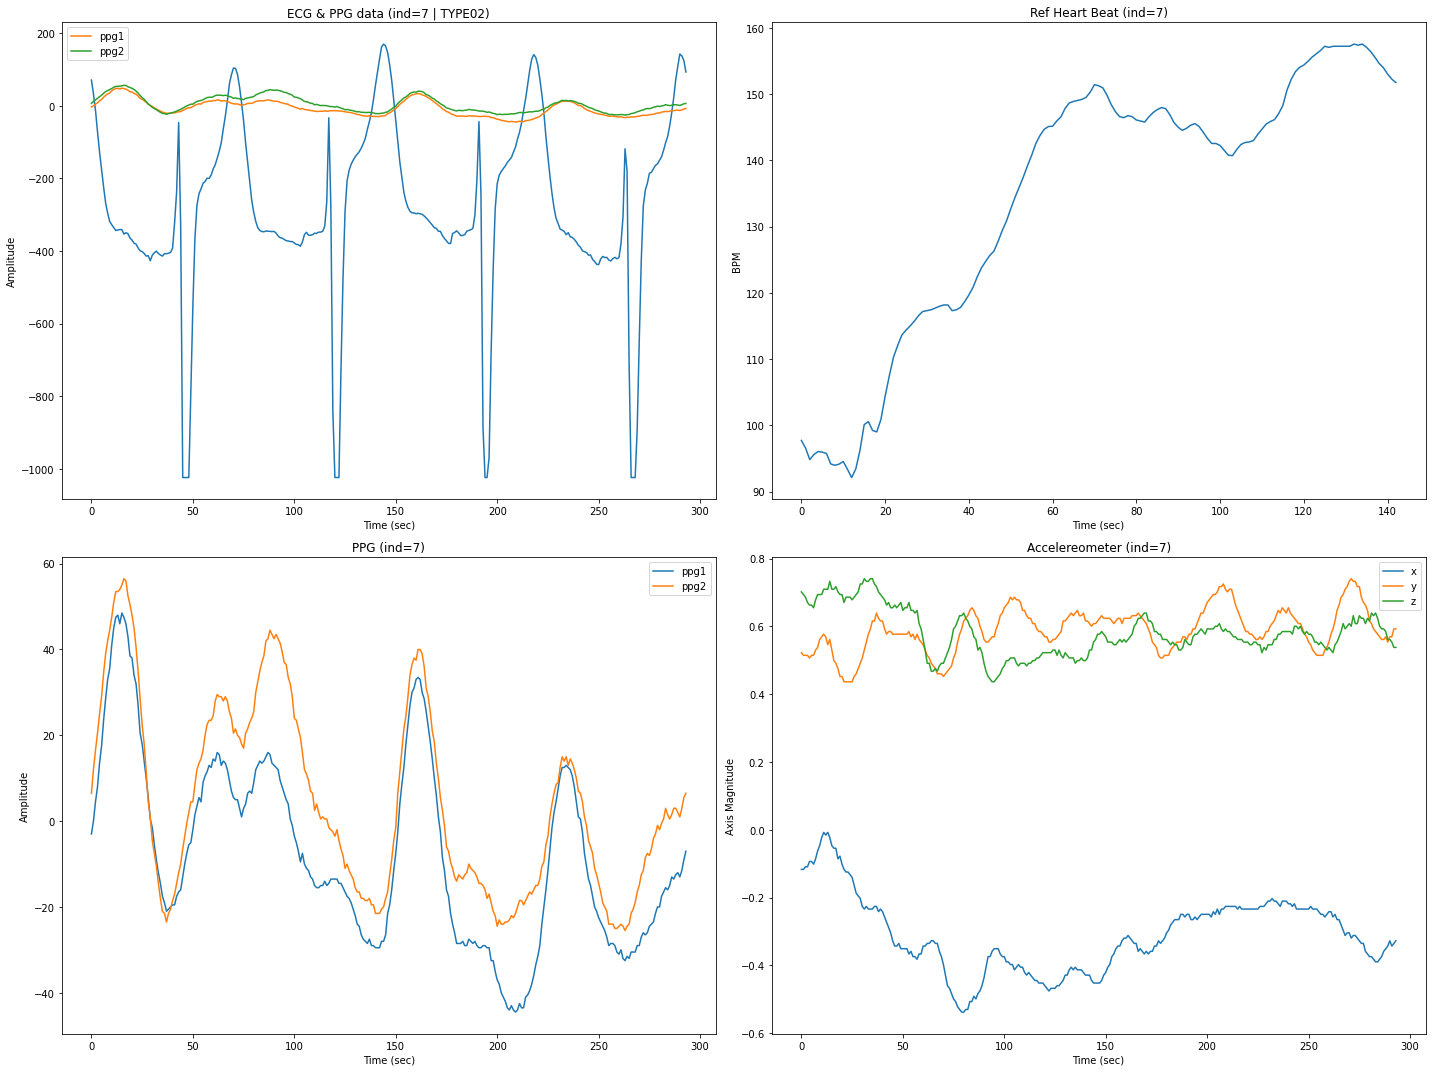

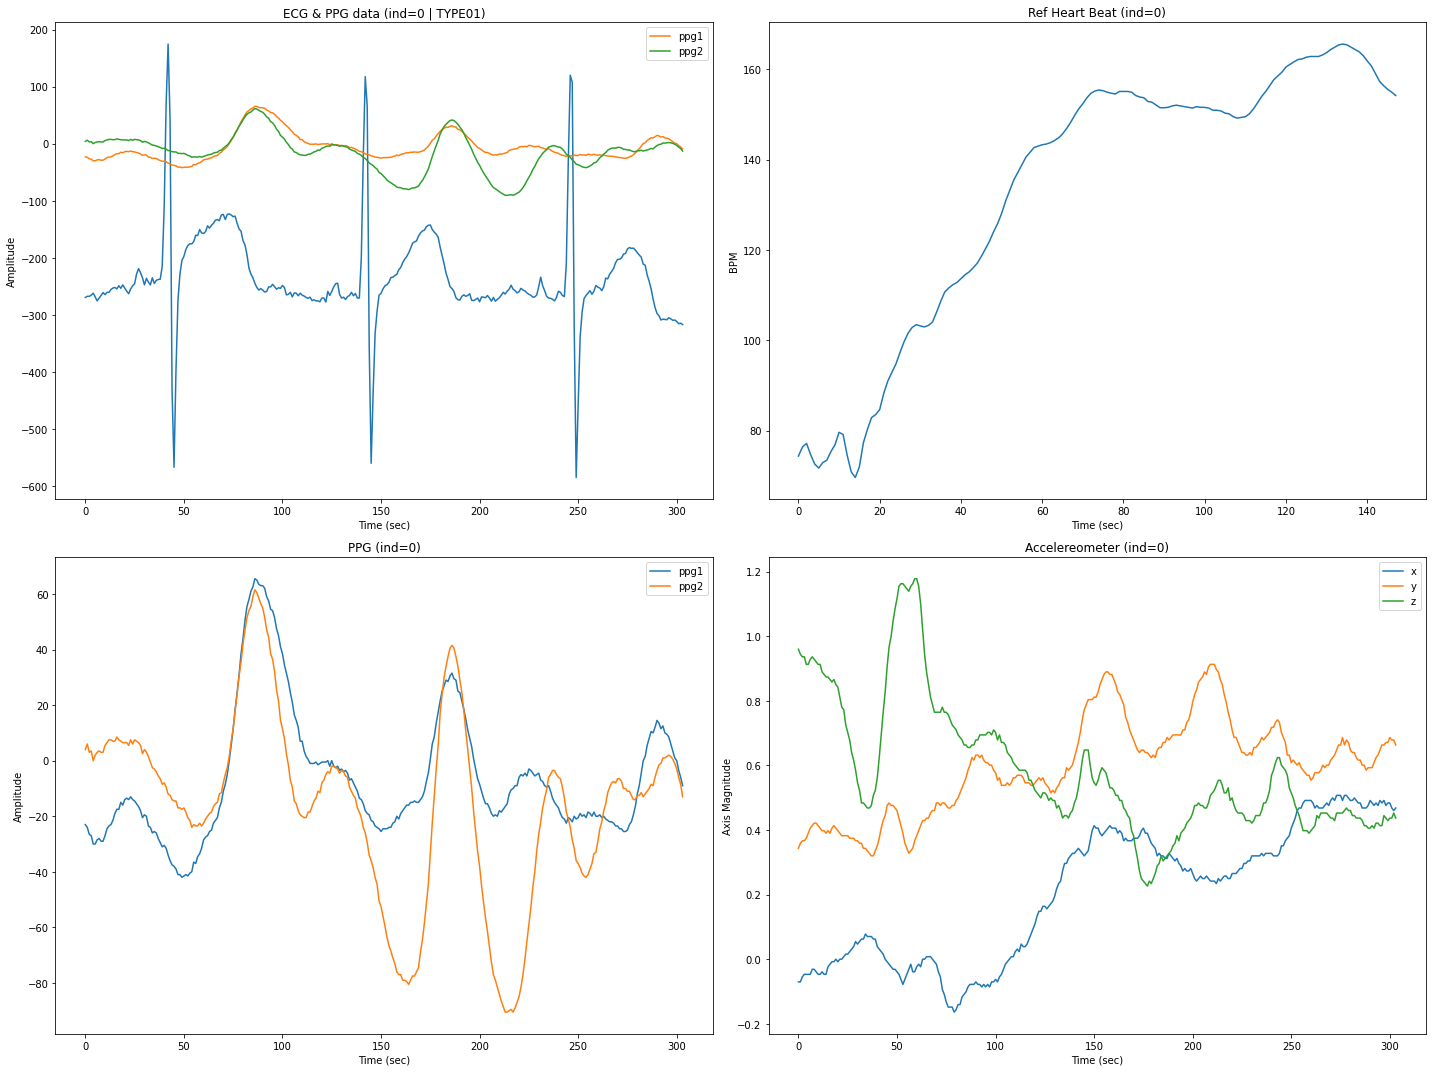

In [4]:
data_explore()

### Code

In [5]:
# Code

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of 
    the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that 
        ref_fls[5] is the reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl, ref_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for data ( with ppg, accx, accy, accz signals), 
        and the ground truth BPM signal.
    """
    data = scipy.io.loadmat(data_fl)['sig']

    # Load ground truth BPM signal.
    ref = scipy.io.loadmat(ref_fl)['BPM0']
    return data[2:], ref


def BandpassFilter(signal, bandpass=(40/60, 240/60), fs=125):
    """
    Apply a bandpass filter to remove frequencies beyond the range of 
    40BPM to 240BPM.

    Args:
        signal (array_like): signal to be filtered.
        bandpass (tuple, optional): The critical frequencies for bandpass filters.
            Defaults to (40/60, 240/60).
        fs (float, optional): The sampling frequency of the digital system.
            Defaults to 125.

    Returns:
        y (ndarray): The filtered output with the same shape as <signal>.
    """
    b, a = scipy.signal.butter(3, Wn=bandpass, btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, signal)


def SpectralDensity(sig, fs=125, plt_show=False):
    """
    Compute the spectral density of data in <sig>, with the option to plot
    the spectrogram as a colormap. Sort the spectrum in descending order.

    Args:
        sig (array): Array containing the data.
        fs (float, optional): The sampling frequency, which is used to calculate
            the Fourier frequencies. Defaults to 125Hz.
        plt_show (bool, optional): Whether to plot the colormap of the spectrogram.
            Defaults to False.

    Returns:
        sig_spec (2D array): Spectrum of <signal>.
        freqs (1-D array): The frequencies corresponding to the rows in <sig_spec>.
        ind (ndarray, int): Array of indices that sort sig_spec in descending order
            along the first axis.
    """
    lo, hi = 40/60, 240/60
    sig_spec, freqs, im, _ = plt.specgram(sig, NFFT=8*fs, noverlap=6*fs, Fs=fs)
    sig_spec = sig_spec[(freqs >= lo) & (freqs <= hi)]
    freqs = freqs[(freqs >= lo) & (freqs <= hi)]
    ind = (-sig_spec).argsort(axis=0)
    if plt_show:
        print('Spectra Plotted.')
        plt.show()
    else:
        plt.close()
    return sig_spec, freqs, ind


def EstimateFreq(ppg, accx, accy, accz, ref, fs=125):
    """
    Analyze segments of PPG and Accelerometer signals to estimate the pulse rate
    and evaluate the estimates with the MAE and the confidence value.

    Args:
        ppg (numpy array): Array contains PPG signal.
        accx/y/z ([numpy arrays]): Arrays with accelerometer signal per axis.
        ref (numpy array): Array with ground truth/reference data.
        fs (float, optional): The sampling frequency. Defaults to 125.

    Returns:
        errors (list): The mean absolute error for heart rate prediction.
        confidence (list): the confidence estimate (See EvaluateEstimate())
    """

    # Retrieve power spectral density and sorted index.
    ppg_spec, ppg_freqs, ppg_ind = SpectralDensity(ppg)
    ax_spec, ax_freqs, ax_ind = SpectralDensity(accx)
    ay_spec, ay_freqs, ay_ind = SpectralDensity(accy)
    az_spec, az_freqs, az_ind = SpectralDensity(accz)

    estimate_freq = []
    for idx in range(ppg_spec.shape[1]):
        for freq in range(len(ppg_freqs)):
            if freq == 9:
                estimate_freq.append(ppg_freqs[ppg_ind[freq][idx]])
                break
            elif np.all([(ppg_freqs[ppg_ind[freq][idx]] != ax_freqs[ax_ind[0][idx]]),
                         (ppg_freqs[ppg_ind[freq][idx]]
                          != ay_freqs[ay_ind[0][idx]]),
                         (ppg_freqs[ppg_ind[freq][idx]]
                          != az_freqs[az_ind[0][idx]]),
                         (ppg_freqs[ppg_ind[freq][idx]]
                          != ax_freqs[ax_ind[1][idx]]),
                         (ppg_freqs[ppg_ind[freq][idx]]
                          != ay_freqs[ay_ind[1][idx]]),
                         (ppg_freqs[ppg_ind[freq][idx]]
                          != az_freqs[az_ind[1][idx]]),
                         (ppg_freqs[ppg_ind[freq][idx]]
                          != ax_freqs[ax_ind[2][idx]]),
                         (ppg_freqs[ppg_ind[freq][idx]]
                          != ay_freqs[ay_ind[2][idx]]),
                         (ppg_freqs[ppg_ind[freq][idx]] != az_freqs[az_ind[2][idx]])]):
                estimate_freq.append(ppg_freqs[ppg_ind[freq][idx]])
                break
    confidence = []
    errors = []
    for i in range(ppg_spec.shape[1]):
        c = EvaluateEstimate(ppg, estimate_freq[i])
        confidence.append(c)
        error = np.abs(estimate_freq[i] * 60 - ref[i][0])
        errors.append(error)
    return errors, confidence


def EvaluateEstimate(ppg, estimate_freq):
    """Compute the ratio of energy concentrated
    at (near) the estimated frequency to the full signal.

    Args:
        ppg (numpy array): Array with PPG signals.
        estimate_freq: The predicted frequency.

    Returns:
        confidence: Confidence value for the estiamted frequency.
    """
    freqs = np.fft.rfftfreq(len(ppg)*4, 1/125)
    ppg_fft = np.fft.rfft(ppg, len(ppg)*4)
    ppg_fft[freqs <= 40/60] = 0
    ppg_fft[freqs >= 240/60] = 0
    win = 10/60
    fundamental_freq_win = (freqs >= estimate_freq -
                            win) & (freqs <= estimate_freq + win)
    ppg_mag = np.abs(ppg_fft)
    confidence = np.sum(ppg_mag[fundamental_freq_win]) / np.sum(ppg_mag)
    return confidence


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability.

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and 
            corresponding reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate
        error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append((errors))
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Main function to run the algorithm.

    Args:
        data_fl (str): path to a troika .mat file.
        ref_fl (str): path to a .mat reference data

    Returns:
        Evaluation metrics <erros> and <confidence> as numpy arrays.
    """
    fs = 125
    win_len = 8 * fs
    win_shift = 2 * fs

    # Load data using LoadTroikaDataFile
    data, ref = LoadTroikaDataFile(data_fl, ref_fl)
    ppg, accx, accy, accz = map(BandpassFilter, data)

    # Compute pulse rate estimates and estimation confidence for 
    # each segment of windows.
    errors, confidence = EstimateFreq(ppg, accx, accy, accz, ref)

    # Return per-estimate mean absolute error and confidence as 
    # a 2-tuple of numpy arrays.
    return np.array(errors), np.array(confidence)


In [6]:
Evaluate()

14.045445723426615

Model's performance on the testing dataset. 

<img src="test.png" alt="Model's performance on the testing dataset, with MAE of 4.5 BPM.">